In [1]:
cd /home/ubuntu/DistMEC/

/home/ubuntu/DistMEC


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from classes.User import *
from classes.solver import *
from classes.Server import *

In [7]:
def gen_eq_locs(space_1d, nums, offset = 0.5):
    # Generate well spread out locations in square space
    num_across = int(np.floor(np.sqrt(nums)))
    locs = []
    
    inc = space_1d/nums
    
    for i,j in itertools.product(range(num_across), range(num_across)):
        locs += [(i*inc+offset, j*inc+offset)]
    
    return locs

def obtain_w(Users, num_users, num_svrs): # checked
    
    w_curr = np.zeros([num_users,num_svrs])
    for i in range(num_users):
        w_curr[i] = Users[i].reward_scale[Users[i].usr_place]
    
    return w_curr

def update_user_locs(Users): # Checked
    
    for i in range(len(Users)):
        Users[i].next_loc()
    return
    
def get_arms_list(Users): # Checked
    arms = []
    for i in range(len(Users)):
        arms+= [Users[i].choose_arm()]
    return arms

def sort_server_results(arms_list, Servers, Users):

    reserve_id_dict = {}
    reserve_max_val_dict = {}
    reserve_time_dict = {}
    reward_dict = {}
    collision_flag_dict = {}

    for s in range(len(Servers)):
        usr_idxs = np.argwhere(np.array(arms_list) == s).flatten()
        scales = np.zeros(usr_idxs.shape[0])
        w_est = np.zeros(usr_idxs.shape[0])
        stay_times = np.zeros(usr_idxs.shape[0])
        for u in range(usr_idxs.shape[0]):
            scales[u] = Users[usr_idxs[u]].reward_scale[Users[usr_idxs[u]].usr_place,s]
            w_est[u] =  Users[usr_idxs[u]].ucb_raw[s]
            stay_times[u] = Users[usr_idxs[u]].expected_time

        user_list = usr_idxs.tolist()
        scales_list = scales.tolist()
        w_est_list = w_est.tolist()
        stay_times_list = stay_times.tolist()

        s_result = Servers[s].receive_users(user_list, scales_list, w_est_list, stay_times_list, len(Users))
        reserve_id, reserve_max_val, reserve_time, reward, collision_flag = s_result[0],s_result[1],s_result[2],s_result[3],s_result[4]
        reserve_id_dict[s] = reserve_id
        reserve_max_val_dict[s] = reserve_max_val
        reserve_time_dict[s] = reserve_time
        reward_dict[s] = reward
        collision_flag_dict[s] = collision_flag
    
    return reserve_id_dict,reserve_max_val_dict ,reserve_time_dict ,reward_dict , collision_flag_dict


def update_user_info(Users, arms_list, reserve_id_dict,reserve_max_val_dict ,
                     reserve_time_dict ,reward_dict ,collision_flag_dict):
    # update UCB information from user 
    for u in range(len(Users)):
        arm_id = arms_list[u]
        reward = reward_dict[arm_id]
        collision_flag = collision_flag_dict[arm_id]
        max_reward = reserve_max_val_dict[arm_id]
        wait_time = reserve_time_dict[arm_id]
        chosen_idx = reserve_id_dict[arm_id]
        Users[u].receive_reward(arm_id, reward, collision_flag, max_reward, wait_time, chosen_idx)
    return


def expected_reward_collision_sensing(arms, mus, w):
    exp_mus = np.zeros(len(arms))
    collision_counter = 0
    seen = []
    for i in range(len(arms)):
        num_simul_pulls = np.argwhere(np.array(arms)==arms[i]).flatten().shape[0]
        if num_simul_pulls == 1:
            exp_mus[i] = w[i, arms[i]]* mus[i, arms[i]]
        else:
            collision_counter += 1
        
    return np.sum(exp_mus), collision_counter

def get_user_locs(Users):
    usr_loc_list = []
    for i in range(len(Users)):
        usr_loc_list += [Users[i].usr_place]
        
    return usr_loc_list

In [18]:
def explore_rounds(Users, num_users, num_svrs, mu, regret, usr_move_flag = False,
              rounds=1):

    arms = list(range(num_users)) 

    for j in range(rounds):
        for i in range(num_svrs):
            w = obtain_w(Users, num_users, num_svrs)
            optimal = offline_optimal_action(w, mu)
            reward_exp_now, collision_count[i] = expected_reward_collision_sensing(arms, mu, w)
            regret[i] = optimal[1] - reward_exp_now

            svr_res = sort_server_results(arms, Servers, Users)
            update_user_info(Users, arms, svr_res[0], svr_res[1], svr_res[2], svr_res[3], svr_res[4])
            if usr_move_flag:
                update_user_locs(Users)

            arms = sweep_init_next(arms, num_svrs)
    
    return
    
def play_round(Users, num_users, num_svrs, mu, regret, usr_move_flag = False,
              debugger = False):
    
    t = int(np.sum(Users[0].pulls))
    
    w = obtain_w(Users, num_users, num_svrs)
    optimal = offline_optimal_action(w, mu)
    
    
    if debugger:
        print("time:", t)
        
        print("\nmu")
        print(mu)
    
        print("\nest mu")
        for i in range(len(Users)):
            print(Users[i].param_summed/Users[i].pulls)

        print("\nuser w")
        for i in range(len(Users)):
            print(Users[i].reward_scale[Users[i].usr_place])

        print("\nscaled_reward")    
        for i in range(len(Users)):
            print(Users[i].reward_scale[Users[i].usr_place] * mu[i])
            
        print("\nraw ucb")
        for i in range(len(Users)):
            print(Users[i].ucb_raw)
            
        print("\nscaled_ucb")    
        for i in range(len(Users)):
            print(Users[i].reward_scale[Users[i].usr_place] * Users[i].ucb_raw)

        print("\nuser pulls")
        for i in range(len(Users)):
            print(Users[i].pulls)

        print("\nuser locs")
        locci = []
        for i in range(len(Users)):
            locci += [Users[i].usr_place]
        print(locci)

    
    arms = get_arms_list(Users)
    reward_exp_now, collision_count[t] = expected_reward_collision_sensing(arms, mu, w)
    regret[t] = optimal[1] - reward_exp_now
    svr_res = sort_server_results(arms, Servers, Users)
    update_user_info(Users, arms, svr_res[0], svr_res[1], svr_res[2], svr_res[3], svr_res[4])
    if usr_move_flag:
        update_user_locs(Users)
        
    if debugger:
        
        print("\noptimal arms")
        print(optimal[0])
        
        print("\nchosen arms")
        print(arms)
        
        # Advanced
        print("\nmax log")    
        for i in range(len(Users)):
            print(Users[i].max_logs)
            
        print("\nwait times")    
        for i in range(len(Users)):
            print(Users[i].wait_times)
        
        print("\nregret")
        print(regret[t])
            
#     return
    return svr_res

In [109]:
# System Parameters
T = 5000
num_users = 2
num_svrs = 4
num_locs = 4
mu = np.random.uniform(low=0, high = 1, size = [num_users, num_svrs])
# w = np.random.uniform(low=0, high=1, size= [num_users, num_svrs])

# Generate visitng locations and server locations
space_1d_dim = 10 #4 for small, 10 for big
usr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_locs)
svr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_svrs)

# Create Users
Users = []
for i in range(num_users):
    Users += [User(usr_locs,svr_locs,mu[i],i,
                  max_dist = 7, threshold_dist = 6, self_weight = 1 - 0.95, P = None, ceiling = 10)]
    
# Create Servers
Servers = []
for i in range(num_svrs):
    Servers += [Server(svr_locs[i],mu,i)]

# Recorded Values
rewards_record = np.zeros([num_users,num_svrs])
pulls_record = np.zeros([num_users,num_svrs])
ucb = np.zeros([num_users,num_svrs])
regret = np.zeros(T)
collision_count = np.zeros(T)    

In [110]:
explore_rounds(Users, num_users, num_svrs, mu, regret, usr_move_flag = False,
              rounds=1)

for t in range(i+1, T-1):
    play_round(Users, num_users, num_svrs, mu, regret, usr_move_flag = False,
              debugger = False)
    
play_round(Users, num_users, num_svrs, mu, regret, usr_move_flag = False,
              debugger = True)

time: 4999

mu
[[0.79196286 0.27298845 0.92451237 0.54137721]
 [0.30023852 0.76168881 0.73024444 0.37483715]]

est mu
[0.78777417 0.         0.91935484 0.57142857]
[0.6        0.76610786 0.54545455 0.41176471]

user w
[1.         0.64285714 0.64285714 0.49492373]
[0.64285714 1.         0.49492373 0.64285714]

scaled_reward
[0.79196286 0.17549258 0.59432938 0.26794043]
[0.19301048 0.76168881 0.3614153  0.24096674]

raw ucb
[0.82936371 1.19142724 1.28999059 1.67447586]
[1.25257157 0.80758384 1.42538188 1.11957796]

scaled_ucb
[0.82936371 0.76591751 0.82927966 0.82873783]
[0.80522458 0.80758384 0.70545531 0.71972869]

user pulls
[4924.    6.   62.    7.]
[  20. 4951.   11.   17.]

user locs
[0, 1]

optimal arms
[0, 1]

chosen arms
[0, 1]

max log
[0. 0. 0. 0.]
[0. 0. 0. 0.]

wait times
[0. 0. 0. 0.]
[0. 0. 0. 0.]

regret
0.0


({0: 0, 1: 1, 2: None, 3: None},
 {0: 0.829363708349544, 1: 0.8075838398609102, 2: None, 3: None},
 {0: 8.0, 1: 10.0, 2: None, 3: None},
 {0: array([1., 0.]), 1: array([0., 1.]), 2: None, 3: None},
 {0: False, 1: False, 2: False, 3: False})

Text(0, 0.5, 'Regret')

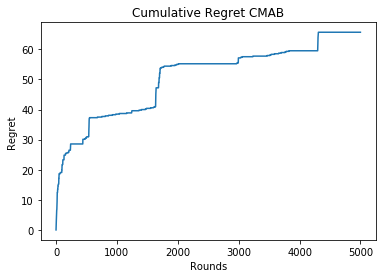

In [111]:
plt.plot(np.cumsum(regret))
plt.title('Cumulative Regret CMAB')
plt.xlabel('Rounds')
plt.ylabel('Regret')

Text(0, 0.5, 'Regret')

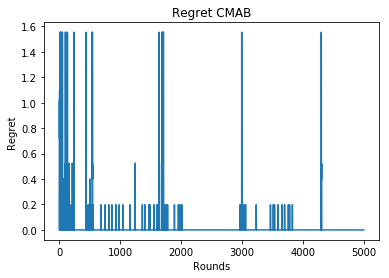

In [112]:
plt.plot(regret)
plt.title('Regret CMAB')
plt.xlabel('Rounds')
plt.ylabel('Regret')

Text(0, 0.5, 'Colliding Users')

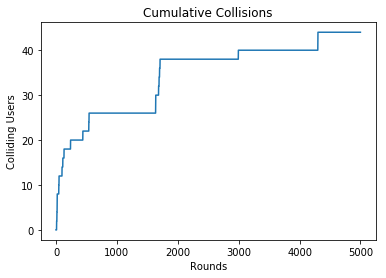

In [113]:
plt.plot(np.cumsum(collision_count))
plt.title('Cumulative Collisions')
plt.xlabel('Rounds')
plt.ylabel('Colliding Users')

Text(0, 0.5, 'Colliding Users')

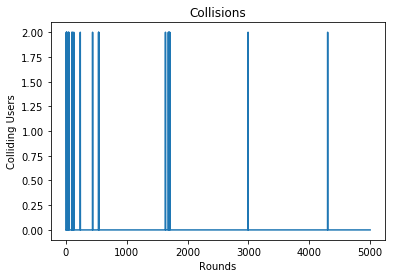

In [114]:
plt.plot(collision_count)
plt.title('Collisions')
plt.xlabel('Rounds')
plt.ylabel('Colliding Users')

In [115]:
(np.cumsum(collision_count)[-1]/len(Users))/T

0.0044

In [116]:
ET = []

for i in range(len(Users)):
    ET += [Users[i].expected_time]

print("Expected times:", ET)

Expected times: [8.0, 10]
